In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code"></form>''')

In [2]:
%pylab inline

import os
from PyTools import integrated_flux

rc("text", usetex=False)
rc("font", family="sans-serif", serif="Arial", size=12)
rc("savefig", dpi=92)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def ccm(wlength, Av, Rv=3.1):
    x = 1.e4 / wlength

#	Infrared:  Eq. 2
    if x >= 0.3 and x < 1.1:
        a= 0.574*x**1.61
        b= -0.527*x**1.61
#	Optical/NIR:  Eq. 3
    elif x >= 1.1 and x < 3.3:
        y=x-1.82
        a=1.+0.17699*y-0.50447*y**2-0.02427*y**3+0.72085*y**4+0.01979*y**5-0.77530*y**6+0.32999*y**7
        b=1.41338*y+2.28305*y**2+1.07233*y**3-5.38434*y**4-0.62251*y**5+5.30260*y**6-2.09002*y**7
#	Ultraviolet:  Eq.4
    elif x >= 3.3 and x < 8.:
        fa=0.
        fb=0.
        if x >= 5.9:
            fa=-0.04473*(x-5.9)**2-0.009779*(x-5.9)**3
            fb=0.2130*(x-5.9)**2+0.1207*(x-5.9)**3
        a=1.752-0.316*x-0.104/((x-4.67)**2+0.341)+fa
        b=-3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
#	Far-UV:  Eq. 5
    elif x >= 8 and x <= 10.:
        a=-1.073-0.628*(x-8.)+0.137*(x-8.)**2-0.070*(x-8)**3
        b=13.670+4.257*(x-8)-0.420*(x-8)**2+0.374*(x-8)**3
    else:
        return 0.0

    return 10 ** (-0.4 * Av * (a + b / Rv))

In [4]:
obs_res = 0.0
bas_res = 0.0

rband = loadtxt("../inputs/SDSS_filters.txt")
rband = rband[47+89:47+89+75]

odir = "../../Mateu+2015/"
bdir = "../../STARLIGHTv04/Bases_gaspex/"

out_list = sorted([os.path.join(root, file) for root, subs, files in os.walk(odir) for file in files if file.endswith("gp.log")])
bas_list = sorted([os.path.join(root, file) for root, subs, files in os.walk(bdir) for file in files if file.endswith(".spec")])

wlength, base = loadtxt(bas_list[0], unpack=True)
for file in bas_list[1:]: base = np.vstack((base, loadtxt(file, usecols=(1,))))

nl = [6003, 5997]
nb = [7, 5]
    
sl_table = []
sws, fnorm = [], []
st = []
for j, file in enumerate(out_list):
    with open(file, "r") as f:
        line = f.readline()[:-1]
        
        while "fobs_norm" not in line: line = f.readline()[:-1]
        fnorm.append(eval(line.split()[0]))
    
        while "adev" not in line: line = f.readline()[:-1]
        mean_residual = eval(line.split()[0])
    
        while "Mcor_tot" not in line: line = f.readline()[:-1]
        mass = eval(line.split()[0])
        
        while "vd" not in line: line = f.readline()[:-1]
        losvd = sqrt(eval(line.split()[0])**2 - obs_res**2 - bas_res**2)
        
        line = f.readline()[:-1]
        Av = eval(line.split()[0])
        
        f.readline()
        f.readline()
        
        table = genfromtxt(f, dtype=None, usecols=(3, 4, 5, 9), skip_footer=nl[j]-76-nb[j]+1)
        print table.size
        
        M_j, ages, mets, ised_id = table["f0"], table["f1"], table["f2"], table["f3"]
        st.append(ages)
        sws.append(M_j/100.*mass)

    rflx = []
    for i in xrange(ages.size):
        #base[i] = base[i]*array([ccm(wl, Av, Rv=3.1) for wl in wlength])
        rflx.append(integrated_flux(np.vstack((wlength, base[i])).T, rband))
    
    rflx = array(rflx)

    lwla = average(log10(ages), weights=M_j/100.*rflx)
    mwla = average(log10(ages), weights=M_j/100.)
    lwlz = average(log10(mets/0.02), weights=M_j/100.*rflx)
    mwlz = average(log10(mets/0.02), weights=M_j/100.)
    
    sl_table.append([mass, mwla, lwla, mwlz, lwlz, Av, losvd])

7
5


In [5]:
t = log10(array([1.78e5, 4.17e6, 8.71e6, 1.91e7, 3.60e7, 9.05e7, 3.60e8, 1.28e9, 2.75e9, 4.75e9, 9.25e9, 13.75e9]))
rw1 = (array(range(12))+1.0)/10
rw2 = rw1[::-1]

st1, st2 = map(log10, st)
sw1, sw2 = sws

f = open(odir+"example.1", "r")
for i in xrange(9): line = f.readline()[:-1]
dw1 = map(eval, line.split(":")[1].split())
for i in xrange(4): line = f.readline()[:-1]
gw1 = map(eval, line.split(":")[1].split())

tg1 = loadtxt(f)
f.close()

f = open(odir+"example.2", "r")
for i in xrange(9): line = f.readline()[:-1]
dw2 = map(eval, line.split(":")[1].split())
for i in xrange(4): line = f.readline()[:-1]
gw2 = map(eval, line.split(":")[1].split())

tg2 = loadtxt(f)
f.close()

#Reporte de ajuste espectral

##Introducción:
La intención de este breve reporte es disipar las posibles dudas que hayan surgido a la luz de los últimos resultados del ajuste espectral, usando los métodos Gaspex, Starlight (SL) y, en menor medida, DynBaS.

##Los ingredientes:
En todos los métodos los ingredientes estelares se tomaron del modelo de población estelar simple (PES) de BC03 con las siguientes propiedades:

- Biblioteca estelar Stelib
- Trayectorias evolutivas de Padova94
- Función inicial de masa de Chabrier03
- Metalicidad solar ($Z=0.02$)

Los modelos de BC03 abarcan un rango de edades estelares entre $t_\star=0$ y $20$Gaños, sin embargo, Gaspex y SL usan una versión reducida como base espectral, que además, no son iguales entre sí. Por simplicidad y consistencia, asumiremos como base espectral los 12 espectros de PESs (espectros base) de Gaspex (Magris+2015), tanto en SL como en DynBaS, y que en principio son los más ortogonales (o menos paralelos) en el espacio de todas las edades y todas las longitudes de onda (desde $91$ hasta $16\times10^5$angstroms). En vista de que los ajustes hechos con Gaspex/DynBaS y SL fueron hechos de manera independiente, vale la pena echar un vistazo a la consistencia de los ingredientes utilizados en ambos casos. En la siguiente figura se muestra una comparación de los espectros base tanto para Gaspex/DynBaS (negro) como para SL (verde):

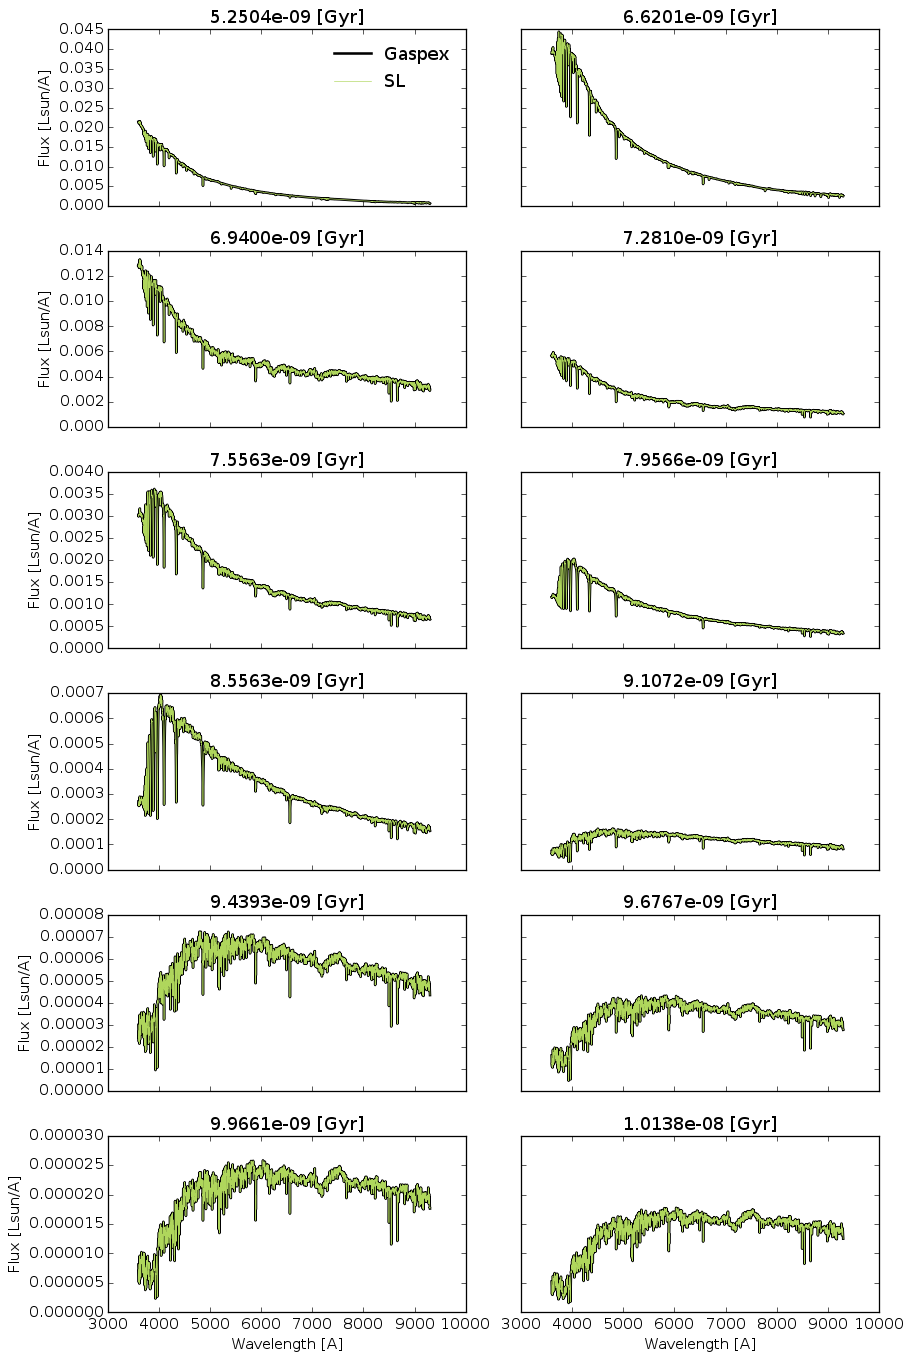

In [6]:
fig, axs = subplots(6, 2, sharex=True, sharey="row", figsize=(10, 15))

axs = axs.ravel()

sl_basis = column_stack((wlength, base.T))#loadtxt(odir+"bc2003_hr_stelib_m62_chab_ssp.ised")
gs_basis = tg1[:, [0]+range(4, 16)]

for i, ax in enumerate(axs):
    ax.set_title("{0:.4e} [Gyr]".format(t[i]/1e9))
    ax.plot(gs_basis[:, 0], gs_basis[:, i+1], "-k", lw=2, label="Gaspex")
    ax.plot(sl_basis[:, 0], sl_basis[:, i+1], "-", lw=0.5, label="SL")
    if i==0: ax.legend(loc=0)
    if i in range(0, 12, 2): ax.set_ylabel("Flux [Lsun/A]")
    if i in [10, 11]: ax.set_xlabel("Wavelength [A]")

fig.tight_layout()

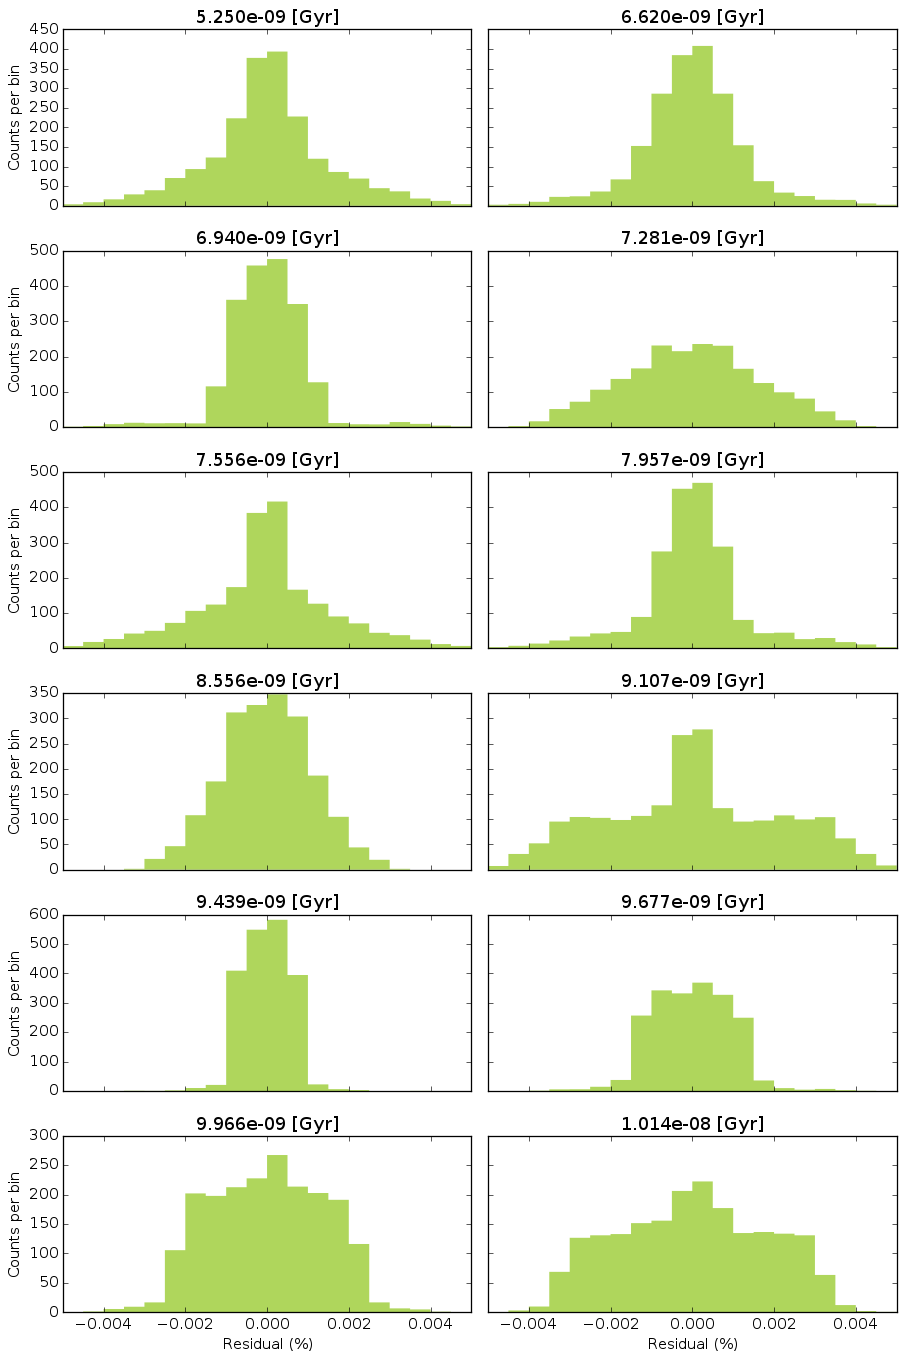

In [7]:
fig, axs = subplots(6, 2, sharex=True, sharey="row", figsize=(10, 15))

axs = axs.ravel()
xlim(-5e-3,+5e-3)
for i, ax in enumerate(axs):
    ax.set_title("{0:.3e} [Gyr]".format(t[i]/1e9))
    ax.hist((sl_basis[:, i+1]-gs_basis[:, i+1])/gs_basis[:, i+1]*100., 20, histtype="stepfilled", lw=0, range=(-5e-3,+5e-3), normed=True)
    if i in range(0, 12, 2): ax.set_ylabel("Counts per bin")
    if i in [10, 11]: ax.set_xlabel("Residual (%)")

fig.tight_layout()

##Los espectros problema y sus soluciones
Los dos espectros *target* de este trabajo (hasta ahora) fueron construidos combinando linealmente los espectros base, en un caso con pesos que crecen con la edad (example.1) y, en el otro, con pesos que decrecen con la edad (example.2), como se muestra en la siguiente figura:

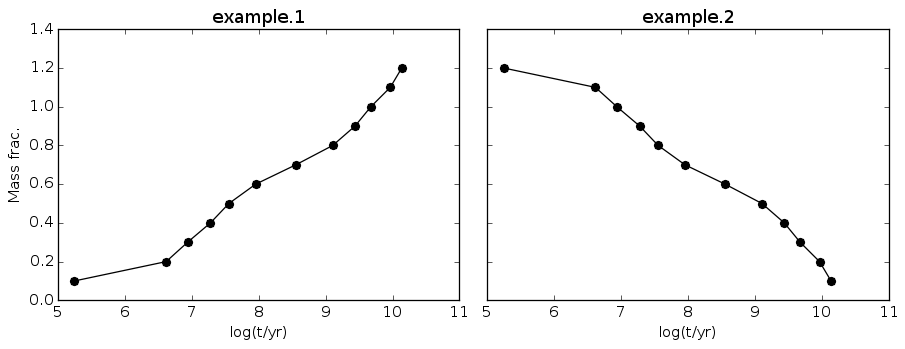

In [8]:
fig, (ax1, ax2) = subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))

ax1.set_title("example.1")
ax1.plot(t, rw1, "-ok")
ax1.set_xlabel("log(t/yr)")
ax1.set_ylabel("Mass frac.")

ax2.set_title("example.2")
ax2.plot(t, rw2, "-ok")
ax2.set_xlabel("log(t/yr)")

ylim(0, 1.4)

fig.tight_layout()

Nuevamente por simplicidad se han obviado los efectos de extinción interna y cinemáticos que suelen afectar a los espectros de galaxias. De esta forma, los espectros resultantes se muestran en la siguiente figura (negro) junto con los espectros solución en el caso Gaspex (verde):

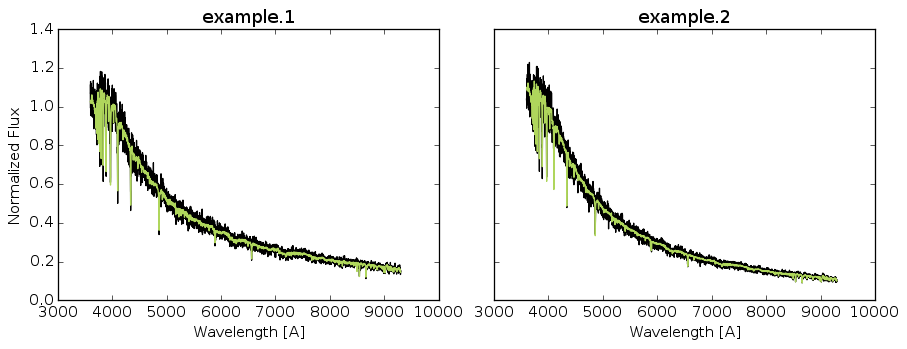

In [9]:
fig, axs = subplots(1, len(out_list), sharey=True, figsize=(10, 4))

axs[0].set_title("example.1")
axs[0].plot(tg1[:, 0], tg1[:, 3]/fnorm[0], "-k")
#axs[0].plot(wlength, sum([sw1[j]*sl_basis[:, 1+j] for j in xrange(12)], axis=0)/fnorm[0], "-r")
axs[0].plot(tg1[:, 0], sum([gw1[i]*tg1[:, 4+i] for i in xrange(12)], axis=0)/fnorm[0])
axs[0].set_xlabel("Wavelength [A]")
axs[1].set_title("example.2")
axs[1].plot(tg2[:, 0], tg2[:, 3]/fnorm[1], "-k")
#axs[1].plot(wlength, sum([sw2[j]*sl_basis[:, 1+j] for j in xrange(12)], axis=0)/fnorm[1], "-r")
axs[1].plot(tg2[:, 0], sum([gw2[i]*tg2[:, 4+i] for i in xrange(12)], axis=0)/fnorm[1])
axs[1].set_xlabel("Wavelength [A]")

axs[0].set_ylabel("Normalized Flux")
fig.tight_layout()

Igualmente en el caso de SL:

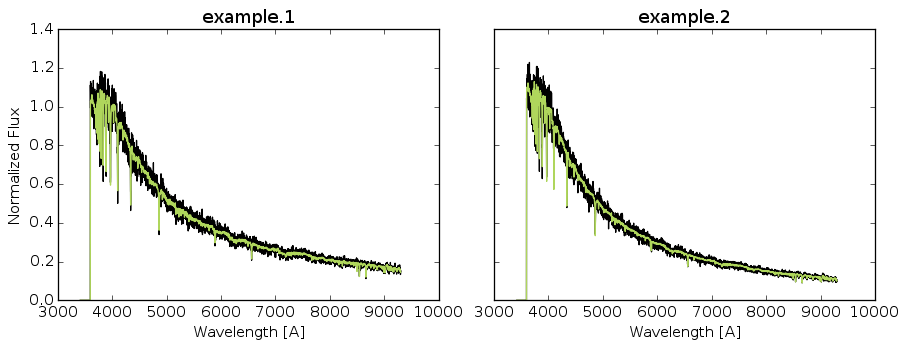

In [10]:
fig, axs = subplots(1, len(out_list), sharey=True, figsize=(10, 4))

for i, file in enumerate(out_list):
    wl, flo, flm = loadtxt(file, skiprows=117, usecols=(0,1,2), unpack=True)
    
    axs[i].set_title("example."+str(i+1))
    axs[i].plot(wl, flo, "-k")
#    if i==0:
#        axs[0].plot(wlength, sum([sw1[j]*sl_basis[:, 1+j] for j in xrange(12)], axis=0)/fnorm[0], "-r")
#    else:
#        axs[1].plot(wlength, sum([sw2[j]*sl_basis[:, 1+j] for j in xrange(12)], axis=0)/fnorm[1], "-r")
    axs[i].plot(wl, flm, "-")
    axs[i].set_xlabel("Wavelength [A]")

axs[0].set_ylabel("Normalized Flux")
fig.tight_layout()

Es claro entonces que el modelado espectral no es problema, pues ambos métodos logran ajustar exitosamente los espectros *target*.

**Nota 1 sobre las soluciones SL:** no pareciera haber una forma obvia de asumir los valores de extinción ($A_V$) y de dispersión de velocidades ($\sigma_\star$), pues SL espera un rango en el que buscar las mejores soluciones para estos parámetros. Sin embargo, se lograron soluciones con $A_V=1\times10^{-4}$ y $\sigma_\star\leq0.04$Km/s.

##Las soluciones físicas
*Un buen ajuste no garantiza las mejores propiedades físicas* o lo que es igual:

[ 5.25042     6.62013605  6.94001816  7.28103337  7.95664858  8.5563025
  9.10720997]
[ 5.25042     6.62013605  6.94001816  7.28103337  8.5563025 ]


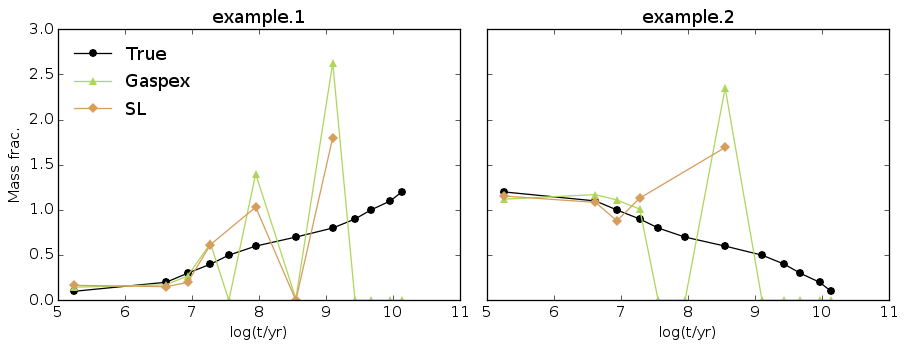

In [13]:
fig, (ax1, ax2) = subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))

ax1.set_title("example.1")
l1,l2,l3,=ax1.plot(t, rw1, "-ok", t, gw1, "-^", st1, sw1, "-D", mew=0)
ax1.legend([l1,l2,l3], ["True", "Gaspex", "SL"], loc=0)
ax1.set_xlabel("log(t/yr)")
ax1.set_ylabel("Mass frac.")

print t[where(array(gw1)>0)[0]]
print t[where(array(gw2)>0)[0]]

ax2.set_title("example.2")
ax2.plot(t, rw2, "-ok", t, gw2, "-^", st2, sw2, "-D", mew=0)
ax2.set_xlabel("log(t/yr)")

fig.tight_layout()

savefig("sfrs", bbox_inches="tight")

**Nota 2 sobre las soluciones SL:** Estas soluciones son diferentes a las que envié en días anteriores, pues he corregido un error en el calculo de los pesos (nada más y nada menos).

###Observaciones:

- **Ningún método** logra recuperar las 4 últimas poblaciones en edad, i.e. $t_\star>1.28$Gaños. Probablemente se debe a la capacidad que tienen las poblaciones recien formadas para rejuvenecer el espectro integrado, haciendo innecesaria la inclusión de poblaciones viejas para obtener un ajuste espectral exitoso.
- SL es mejor (o menos peor) que Gaspex recuperando los pesos de example.1 que Gaspex.
- Gaspex es mejor (o menos peor) que SL recuperando los pesos de los **4 últimos** eventos de formación de example.2. SL recupera es mejor en el global.
- En cuanto a la suma de los pesos (o lo que sería la masa estelar en el caso de una galaxia), ambos espectros tienen valores reales de $7.80$. Gaspex obtiene $5.26$ y $6.76$, mientras que SL obtiene $2.73$ y $5.92$, para example.1 y example.2, respectivamente.